In [3]:
import numpy as np
import math
from functools import partial

from matplotlib import pyplot as plt
from IPython.display import Image
import plotly.figure_factory as ff
import pandas as pd

from sklearn import datasets
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.neighbors import KernelDensity
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import matthews_corrcoef, f1_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

PLOT_SIZE = (18.5, 10.5)

# Uncertainty sampling

In [4]:
def generate_3d_mesh(resolution=0.1):
    for i in np.arange(0, 1, resolution):
        for j in np.arange(0, 1, resolution):
            z = 1 - i - j
            if z >= 0:
                yield i, j, z
    
    yield 1, 0, 0
    yield 0, 1, 0
    
def mesh_data_dict(grid, f):
    return {tuple(row): f(row) for row in grid}

In [5]:
prob_mesh = np.array(list(generate_3d_mesh(0.05)))
prob_mesh = prob_mesh / prob_mesh.sum(axis=1, keepdims=1)

## Binary uncertainty selection in a multi-class setting

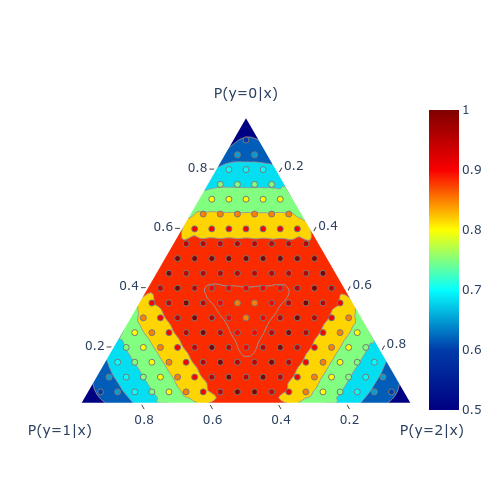

In [6]:
multiclass_uncertainty_bn = 1 - np.abs(0.5 - np.max(prob_mesh, axis=1))

fig = ff.create_ternary_contour(prob_mesh.T, multiclass_uncertainty_bn,
                                pole_labels=['P(y=0|x)', 'P(y=1|x)', 'P(y=2|x)'], colorscale='Jet', showscale=True, showmarkers=True)
fig.write_image("img/binary_uncertainty_multiclass.png")
Image("img/binary_uncertainty_multiclass.png")

In [7]:
prob_mesh[np.argsort(multiclass_uncertainty_bn)[-3:]]

array([[0.1 , 0.4 , 0.5 ],
       [0.5 , 0.  , 0.5 ],
       [0.45, 0.05, 0.5 ]])

## Multiclass-generalization (Strategia 1)

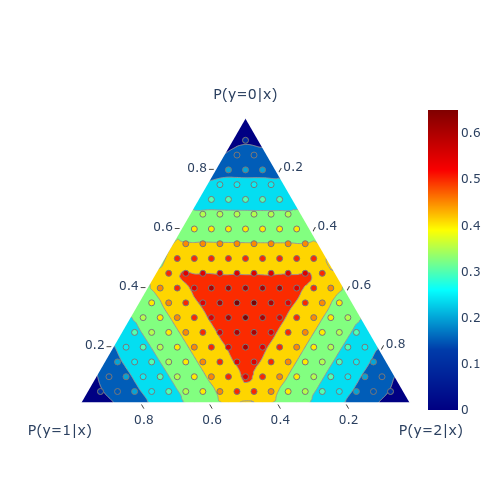

In [8]:
multiclass_uncertainty_st1 = 1 - np.max(prob_mesh, axis=1)

fig = ff.create_ternary_contour(prob_mesh.T, multiclass_uncertainty_st1,
                                pole_labels=['P(y=0|x)', 'P(y=1|x)', 'P(y=2|x)'], colorscale='Jet', showscale=True, showmarkers=True)
fig.write_image("img/binary_uncertainty_multiclass_st1.png")
Image("img/binary_uncertainty_multiclass_st1.png")

In [9]:
prob_mesh[np.argsort(multiclass_uncertainty_st1)[-3:]]

array([[0.3 , 0.35, 0.35],
       [0.35, 0.35, 0.3 ],
       [0.35, 0.3 , 0.35]])

## Multiclass-generalization (Strategia 2)

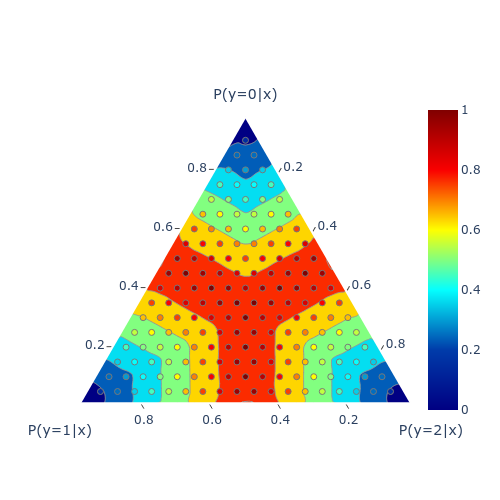

In [10]:
sorted_prob = np.sort(prob_mesh, axis=1)
multiclass_uncertainty_st2 = 1 - (sorted_prob[:, 2] - sorted_prob[:, 1])
fig = ff.create_ternary_contour(prob_mesh.T, multiclass_uncertainty_st2,
                                pole_labels=['P(y=0|x)', 'P(y=1|x)', 'P(y=2|x)'], colorscale='Jet', showscale=True, showmarkers=True)
fig.write_image("img/binary_uncertainty_multiclass_st2.png")
Image("img/binary_uncertainty_multiclass_st2.png")

In [11]:
prob_mesh[np.argsort(multiclass_uncertainty_st2)[-3:]]

array([[0.45, 0.1 , 0.45],
       [0.2 , 0.4 , 0.4 ],
       [0.4 , 0.2 , 0.4 ]])

# Multi-class generation (Shannon entropy)

/tmp/ipykernel_19672/4056593862.py:1: RuntimeWarning:

divide by zero encountered in log



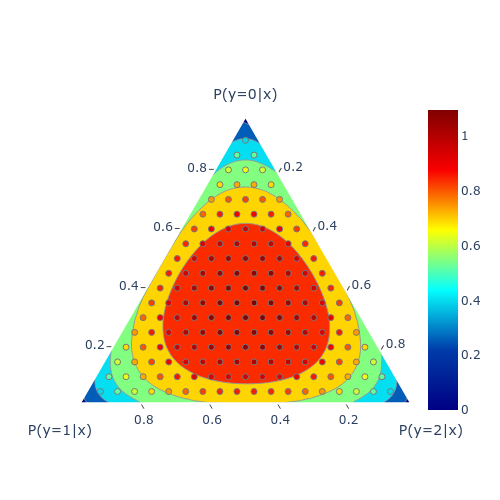

In [12]:
multiclass_uncertainty_et = np.sum(-prob_mesh * np.nan_to_num(np.log(prob_mesh), 0), axis=1)
fig = ff.create_ternary_contour(prob_mesh.T, multiclass_uncertainty_et,
                                pole_labels=['P(y=0|x)', 'P(y=1|x)', 'P(y=2|x)'], colorscale='Jet', showscale=True, showmarkers=True)
fig.write_image("img/uncertainty_multiclass_st_entropy.png")
Image("img/uncertainty_multiclass_st_entropy.png")

In [13]:
prob_mesh[np.argsort(multiclass_uncertainty_et)[-3:]]

array([[0.35, 0.35, 0.3 ],
       [0.3 , 0.35, 0.35],
       [0.35, 0.3 , 0.35]])

# Query-by-comittee

In [14]:
X, y = datasets.make_blobs(400, centers=2, cluster_std=4)
X_train, y_train = X[:150], y[:150]
X_test, y_test = X[len(X_train):], y[len(X_train):]

In [15]:
def boostrap(X_train, y_train, size, random_state=42):
    np.random.seed(random_state)
    idxs = np.random.choice(range(len(X_train)), replace=True, size=size)
    return X_train[idxs], y_train[idxs]

def get_2d_lr_params(clf):
    b = clf.intercept_[0]
    w1, w2 = clf.coef_.T
    c = -b/w2
    m = -w1/w2
    return  m, c

def plot_2d_lr(lr, name):
    slope, intercept = get_2d_lr_params(lr)
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    x_vals[0] -= 10
    x_vals[1] += 10
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', label=name)
    
    
def plot_2d_lrs_al(X_train, y_train, X_test, y_test, n_models, boostrap_size, fitness_measure, show_train=False):
    lrs = []
    
    if show_train:
        plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)
    
    for i in range(n_models):
        lr = LogisticRegression(random_state=12).fit(*boostrap(X_train, y_train, size=boostrap_size, random_state=i))
        lrs.append(lr)
        
    v = fitness_measure(lrs, X_test)
    ltest = plt.scatter(X_test[:, 0], X_test[:, 1], c=v, cmap="plasma")
    plt.gcf().set_size_inches(*PLOT_SIZE)
    plt.colorbar(ltest)
    
    for i, lr in enumerate(lrs):
        plot_2d_lr(lr, name=f"m{i}")
    
    plt.xlim(X_train[:, 0].min() - 1, X_train[:, 0].max() + 1)
    plt.ylim(X_train[:, 1].min() - 1, X_train[:, 1].max() + 1)
    plt.legend()
    
    return lrs

In [16]:
from collections import Counter

def vote_entropy(models, X_test):
    preds = []
    for model in models:
        preds.append(model.predict(X_test))
    
    preds = np.array(preds).T
    fitness = []
    for row in preds:
        counts = Counter(row)
        res = sum(v / len(models) * math.log(v / len(models)) for v in counts.values())
        fitness.append(-res)
        
    return np.array(fitness)

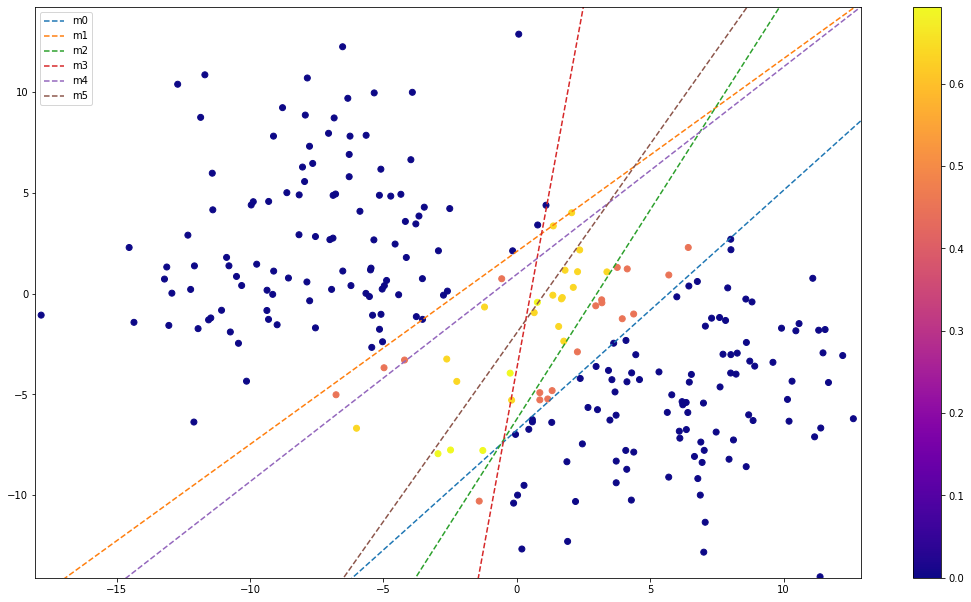

In [17]:
lrs = plot_2d_lrs_al(X_train, y_train, X_test, y_test, 6, 10, vote_entropy)

# Density-weighted methods

In [18]:
X, y = datasets.make_blobs(700, centers=3, cluster_std=3, random_state=42)
y = y % 2
X_train, y_train = X[:500], y[:500]
X_test, y_test = X[len(X_train):], y[len(X_train):]

In [19]:
def cosine_agg_similarity(X, x, agg=np.mean):
    return (1 + agg(cosine_similarity(X, x.reshape(1, -1)))) / 2

def euclidean_agg_similarity(X, x, agg=np.mean):
    return 1 / (1 + agg(np.linalg.norm(X - x, axis=1)))

In [20]:
def all_sym(similarity, X):
    return np.array([similarity(X, x) for x in X])

In [21]:
def uncertainty_fitness(clf, X):
    return 1 - np.abs(0.5 - clf.predict_proba(X)[:, 0])

In [22]:
clf = SVC(probability=True, kernel='rbf')
clf.fit(X_train, y_train);

In [23]:
eclidean_avg_similarity = partial(euclidean_agg_similarity, agg=np.mean)
# Aqui los cuantiles van del reves, ya que se aplica sobre la distancia y esta va en el denominador de la similaridad.
eclidean_qt_similarity = partial(euclidean_agg_similarity, agg=partial(np.quantile, q=0.2))

cosine_avg_similarity = partial(cosine_agg_similarity, agg=np.mean)
cosine_qt_similarity = partial(cosine_agg_similarity, agg=partial(np.quantile, q=0.2))

kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(X_train)

In [24]:
def show_charts(X_train, y_train, X_test, clf, similarity_f, uncertainty_fitness_f):
    fig, subs = plt.subplots(1, 4, figsize=((24, 8)))

    symilarity = similarity_f(X_test)
    uncertainty = uncertainty_fitness_f(X_test)
    density_uncertainty = symilarity * uncertainty
    
    DecisionBoundaryDisplay.from_estimator(
        clf,
        X_train,
        ax= subs[0],
        cmap=plt.cm.RdYlBu,
        response_method="predict"
    )
    
    subs[0].scatter(X_train[:, 0], X_train[:, 1], c=y_train)

    most_similar = np.argmax(symilarity)
    most_uncertain = np.argmax(uncertainty)
    most_combined = np.argmax(symilarity * uncertainty)

    points = subs[1].scatter(X_test[:, 0], X_test[:, 1], c=symilarity)
    subs[1].scatter(X_test[most_similar, 0], X_test[most_similar, 1], marker='x', s=50)
    subs[1].set_title('Similarity')

    points = subs[2].scatter(X_test[:, 0], X_test[:, 1], c=uncertainty)
    subs[2].scatter(X_test[most_uncertain, 0], X_test[most_uncertain, 1], marker='x', s=50)
    subs[2].set_title('Uncertainty')

    points = subs[3].scatter(X_test[:, 0], X_test[:, 1], c=density_uncertainty)
    subs[3].scatter(X_test[most_combined, 0], X_test[most_combined, 1], marker='x', s=50)
    subs[3].set_title('Uncertainty * similarity')

    fig.colorbar(points, ax=subs, location='bottom');

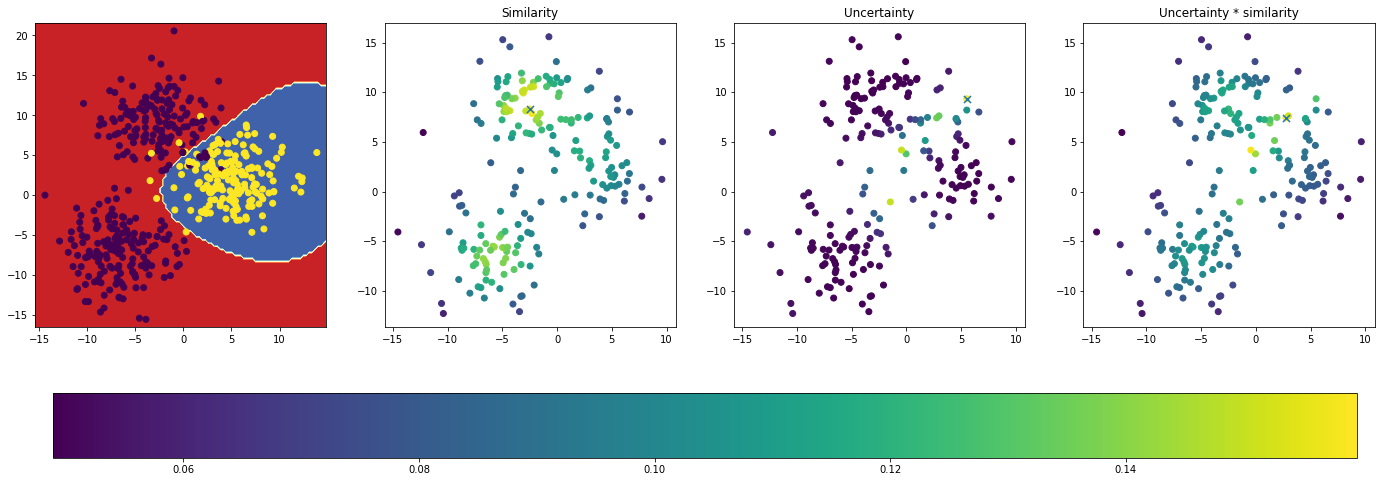

In [25]:
show_charts(X_train, y_train, X_test, clf, partial(all_sym, eclidean_qt_similarity), partial(uncertainty_fitness, clf))

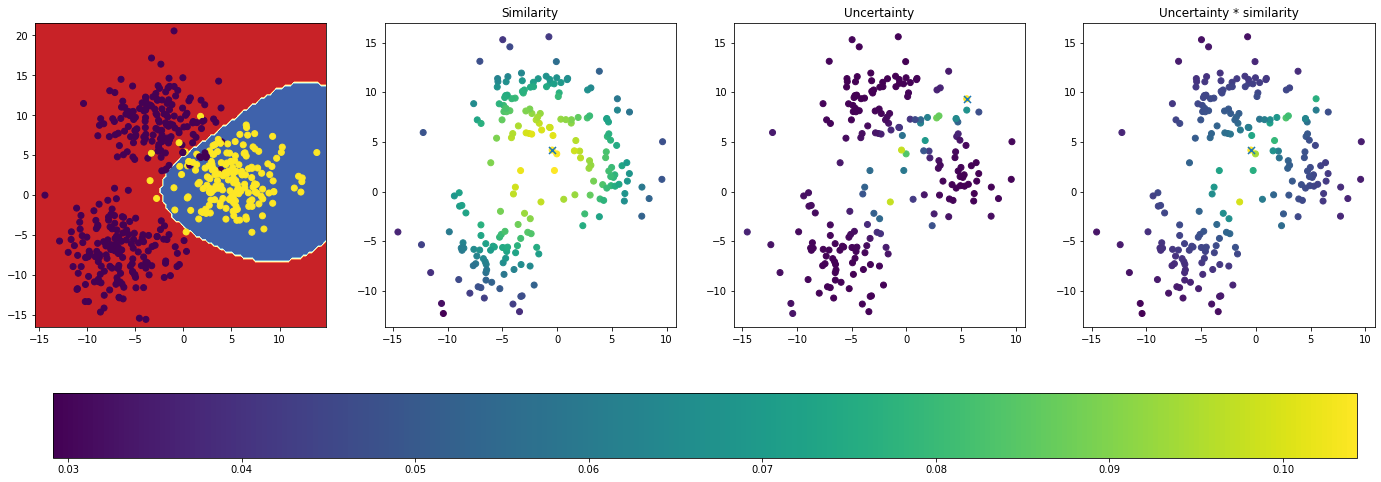

In [26]:
show_charts(X_train, y_train, X_test, clf, partial(all_sym, eclidean_avg_similarity), partial(uncertainty_fitness, clf))

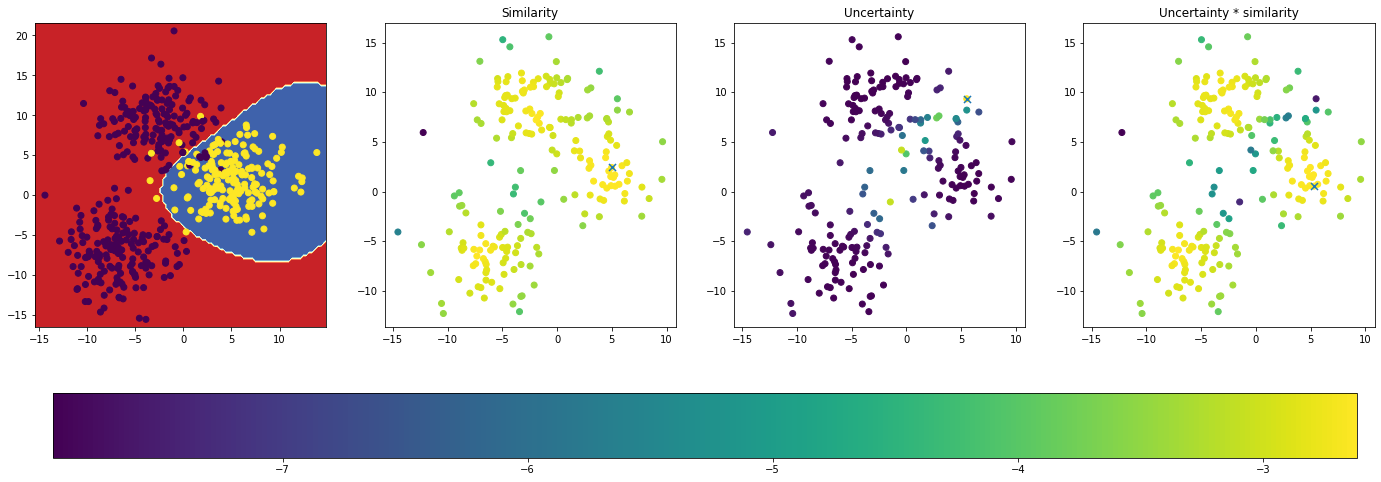

In [27]:
show_charts(X_train, y_train, X_test, clf, kde.score_samples, partial(uncertainty_fitness, clf))

# Entrenar vuestro propio sistema de aprendizaje activo desde 0

In [28]:
X, y = load_breast_cancer(return_X_y=True)
scaler = StandardScaler()
X_t = scaler.fit_transform(X)

In [29]:
# Tip, si queremos acceder a los predictores individuales de un Random forest
# rf = RandomForestClassifier().fit(X, y)
# rf.estimators_[0].predict(X[:10])

In [30]:
def random_sample(clf, X_pool):
    return np.random.choice(range(len(X_pool)))

In [31]:
X_train, X_tv, y_train, y_tv = train_test_split(X_t, y, test_size=0.95, random_state=42)
X_val, X_pool, y_val, y_pool = train_test_split(X_tv, y_tv, test_size=0.5, random_state=42)

clf = RandomForestClassifier().fit(X_train, y_train)
#clf = SVC().fit(X_train, y_train)
#clf = LogisticRegression().fit(X_train, y_train)

metrics = []

BUDGET = 50

for i in range(BUDGET):
    # Seleccionamos una instancia
    idx = random_sample(clf, X_pool) # CAMBIAR EL CODIGO AQUI
    
    # Actualizamos los conjuntos de datos
    X_train = np.concatenate((X_train, X_pool[[idx]]))
    y_train = np.append(y_train, y_pool[idx])
    
    X_pool = np.delete(X_pool, idx, axis=0)
    y_pool = np.delete(y_pool, idx)
    
    clf.fit(X_train, y_train)
    
    metrics.append({
        'iteration': i,
        'f1_score': f1_score(y_val, clf.predict(X_val)),
        'mcc': matthews_corrcoef(y_val, clf.predict(X_val))
    })
    
metrics = pd.DataFrame(metrics)

<AxesSubplot:xlabel='iteration'>

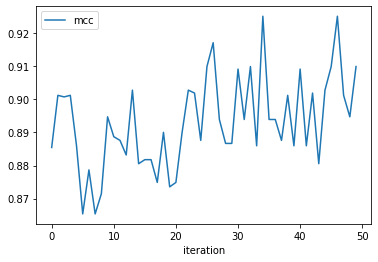

In [33]:
metrics.plot('iteration', 'mcc', kind='line')

<AxesSubplot:xlabel='iteration'>

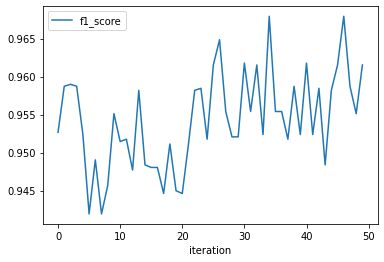

In [34]:
metrics.plot('iteration', 'f1_score', kind='line')

# Ejemplos con modAL

Ver https://modal-python.readthedocs.io/en/latest/